In [1]:
import os

import numpy as np
import pandas as pd
from scipy import signal as sig
from scipy.ndimage import rotate

import matplotlib.pyplot as plt

from typing import Tuple

## Step Through Functions

Build TORS using 2D convolution tor centres for given size.

`ksize`: int, size of the kernel
`arr`: a 2d numpy array that represent the input data

This code defines a function called `kernel` that takes two arguments: `ksize` and `arr`. The `ksize` argument is an integer that specifies the size of the kernel, and the `arr` argument is a two-dimensional numpy array that represents the input data.

The function first creates a kernel matrix `k` using the `np.ones` function, which creates a matrix of ones with the specified size. The `sig.convolve2d` function is then used to convolve the input array `arr` with the kernel `k`. The `mode` parameter is set to `'same'`, which means that the output will have the same shape as the input, and the `boundary` parameter is set to `'wrap'`, which means that the input is assumed to wrap around at the edges.

The resulting convolved array `arrc` is then thresholded so that any values greater than or equal to 1 are set to 1. Finally, the function returns the thresholded array `arrc`.

Overall, this function performs a simple image processing operation known as kernel convolution, which is commonly used in tasks such as edge detection and blurring. The function could be improved by adding more error checking and handling, such as checking that the input array is two-dimensional and that the kernel size is odd. Additionally, the function could be optimized for performance by using more efficient convolution algorithms or by parallelizing the computation.

$$
Z_{c} = \left[\begin{matrix}
a \\
b \\
c
\end{matrix}\right]
;
Z_{r} = \left[\begin{matrix}
d & e & f
\end{matrix}\right]
;
Z_{2d} = \left[\begin{matrix}
0 & a & 0 \\
d & b+e & f \\
0 & c & 0
\end{matrix}\right]
$$

In [2]:
def kernel(ksize: int, arr: np.ndarray) -> np.ndarray:
    """
    Applies a kernel convolution to a 2D numpy array.
    Tor centres to bedrock using scipy.signal.convolve2d

    Args:
        ksize (int): The size of the kernel. Must be a positive odd integer.
        arr (numpy.ndarray): The input 2D numpy array.

    Returns:
        numpy.ndarray: The thresholded output array.

    Raises:
        ValueError: If ksize is not a positive integer or arr is not a 2D numpy array.
    """
    if not isinstance(ksize, int) or ksize <= 0:
        raise ValueError("ksize must be a positive integer")
    if not isinstance(arr, np.ndarray) or arr.ndim != 2:
        raise ValueError("arr must be a 2D numpy array")
    
    
    k = np.ones((ksize, ksize))
    
    arrc = sig.convolve2d(arr, k, mode='same', boundary='wrap')
    arrc[arrc >= 1] = 1
    
    return arrc

In [3]:
def tor_location(length: int, frac: float, scale: int, seed_no: int):
    """
    Generates a synthetic bedrock map using tor locations for a given bedrock fraction.

    Args:
        length (int): The length of the output map.
        frac (float): The desired bedrock fraction.
        scale (int): The size of the kernel used for thresholding.
        seed_no (int): The random seed used for generating the map.

    Returns:
        numpy.ndarray: The thresholded output array.

    Raises:
        ZeroDivisionError: If the matrix returned by kernel() is all zeros.
    """
    ### For Debugging ###
    output = []

    # initialise the output array
    z = np.zeros((length, length))

    # Number of tor locations required to achieve the desired bedrock fraction
    # in a synthetic bedrock map of size length x length.
    # Size of the map, desired bedrock fraction, size of kernel used for thresholding.
    tor_no = int(length*length*(frac)/(scale**2)) # Modified to target BEDROCK FRACTION somewhat easier for me to understand
    
    # tor_no = int(length*length*(1-frac)/(scale**2)) # This is the original code SOIL FRACTION

    # length * length -> total number of cells in the map we need to work over
    # (1-frac) -> the proportion of cells that need to be bedrock, so (1 - 1/10) = 9/10
    # so this seems kind of backwards?  Shouldn't it be length * length * frac?
    # scale is going to control the size of the tor
    # so bigger tors need to fit into the same fraction so we'll get fewer tors
    # Later on in Main -- it's clear we're targeting SOIL FRACTION, not bedrock fraction
    # so this is correct.  We're trying to get a certain amount of soil, not bedrock.
    
    # initialise the iteration counter and the ratio
    i=1
    ratio=0.
    # this can get into this ratio oscillation thing where it's just going back and forth and never trying
    # to converge.  Fix this.  There are only certain envelopes that will work for a given frac and scale.
    # We need a way to fail gracefully.


    # while error > 0.005:
    # make this while loop about the error, not the ratio

    while ratio < 0.995 or ratio > 1.005:
        if i==1:
            tor_no = tor_no
        else:
            tor_no = round(tor_no*ratio)
        # tor density    
        tor_dens = tor_no/(length*length)
        
        np.random.seed(seed_no)
        # uniform over [0, 1)
        z = np.random.random((length,length)) # alias for random.random_sample(), now random.random() is preferred by NumPy  
        z[z <= (1-tor_dens)] = 0
        z[z > (1-tor_dens)] = 1
        z = kernel(ksize=scale, arr=z)
        
        denom = np.sum(z)/(length**2)
        
        try:
            ratio = frac/denom
            error = np.abs(1 - ratio)
        except ZeroDivisionError:
            print('ZeroDivisionError: Unable to Create Map')
            return
            #ratio = None

        ### For Debugging ###           
        output.append([i, ratio, denom])

        if i==50:
            break

        i+=1
    
    if ratio < 0.995 or ratio > 1.005:
        print('Did not converge in fifty iterations.') # Fail more gracefully than this.
    
    return z, output

In [5]:
# Recall scale is changing the size of the kernel used for thresholding.

mat, out = tor_location(length=100, frac=0.2, scale=2, seed_no=166)
print(pd.DataFrame(out).head())

   0         1       2
0  1  1.112966  0.1797
1  2  1.004520  0.1991


In [7]:
mat.shape

(100, 100)

OK, what does what here?

* `frac` increases the proportion of the landscape that are tors
* `scale` increases the size of the tors

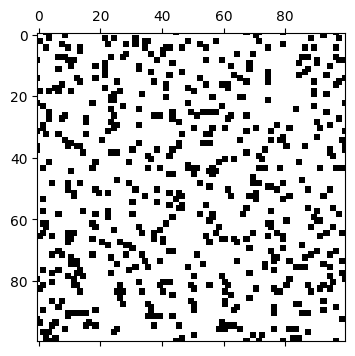

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.matshow(mat, cmap='binary')
plt.show()

### Rotation

This isn't as straight-forward as we'd hoped.  Treat as an image instead of a matrix and use `scipy.ndimage.rotate` now.

In [4]:
def rotate_matrix(mat, theta):
    """
    Rotates a 2D numpy array by a given angle.

    Args:
        mat (numpy.ndarray): The input 2D numpy array.
        theta (float): The angle of rotation in degrees.

    Returns:
        numpy.ndarray: The rotated 2D numpy array.

    """
    from scipy.ndimage import rotate
    new_mat = rotate(mat, angle = theta, reshape = False)
    # Apply a threshold to the rotated matrix to ensure we get back a binary matrix
    new_mat = np.where(new_mat > 0.5, 1, 0)

    return new_mat


In [5]:
matrix = np.array([[1, 0, 1],
                   [0, 0, 0],
                   [0, 1, 1]])

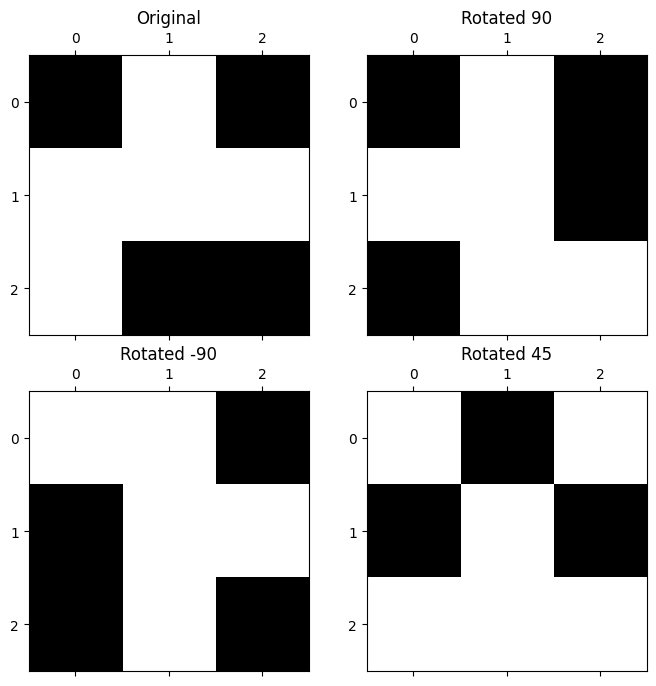

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0,0].matshow(matrix, cmap='binary')
ax[0,0].set_title('Original')
ax[0,1].matshow(rotate_matrix(matrix, 90), cmap='binary')
ax[0,1].set_title('Rotated 90')
ax[1,0].matshow(rotate_matrix(matrix, -90), cmap='binary')
ax[1,0].set_title('Rotated -90')
ax[1,1].matshow(rotate_matrix(matrix, 45), cmap='binary')
ax[1,1].set_title('Rotated 45')
plt.show()

Did not converge in fifty iterations.


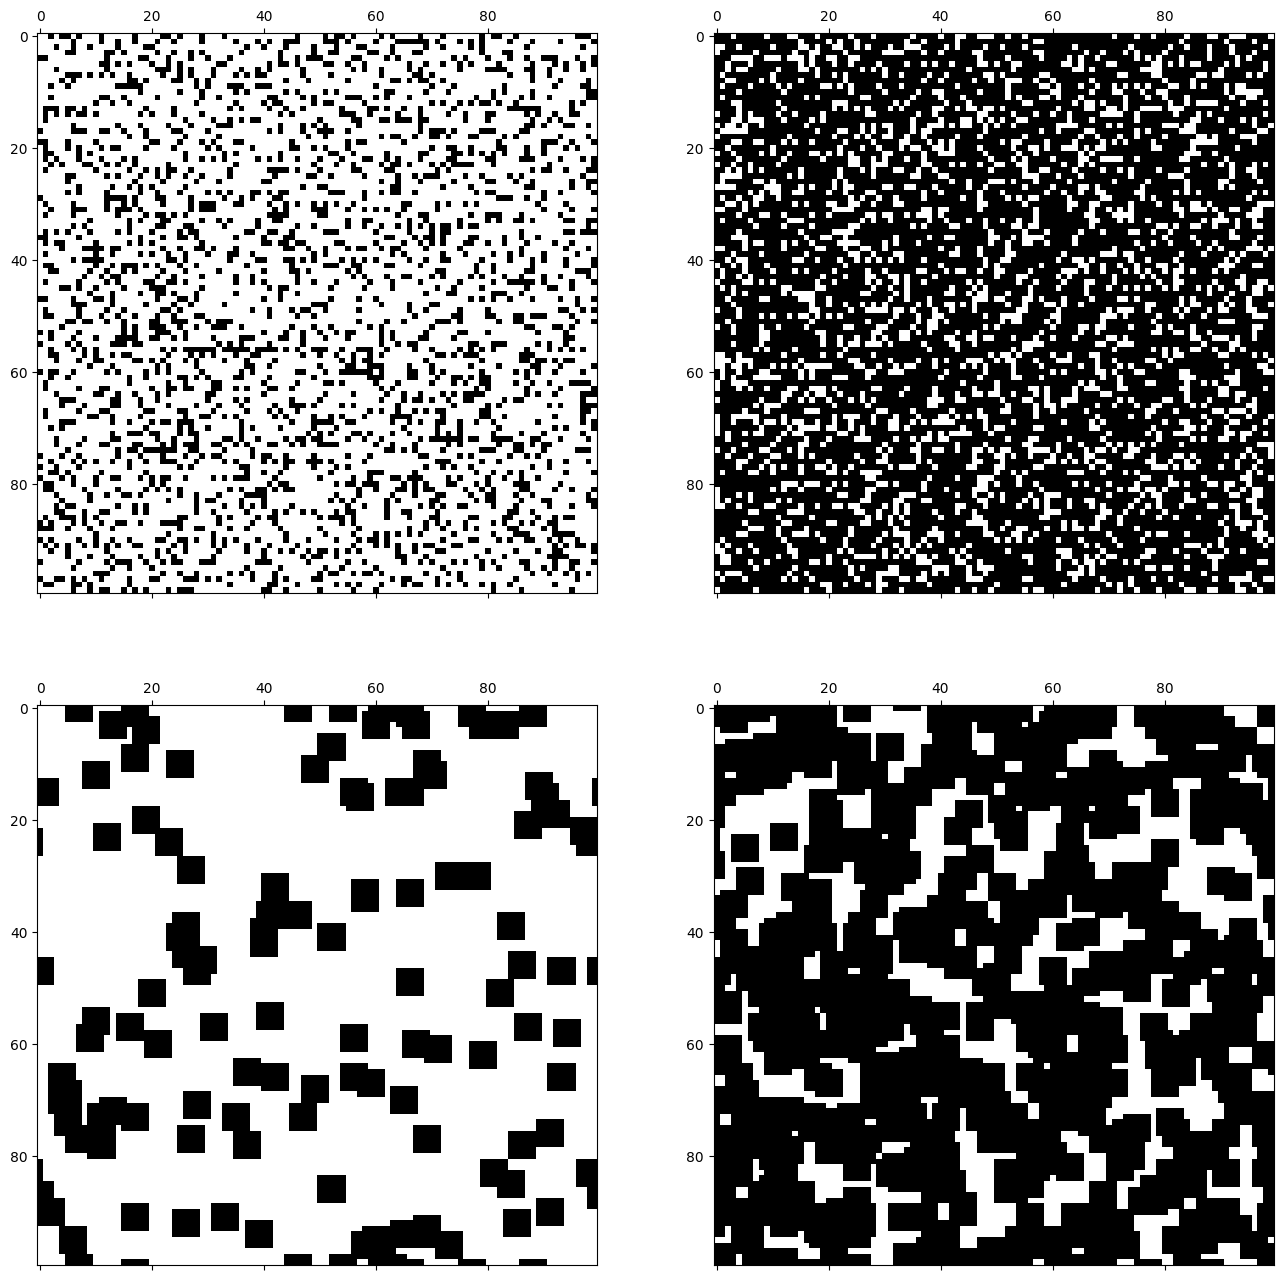

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(16,16))

mat1, _ = tor_location(length=100, frac=0.25, scale=1, seed_no=18)
ax[0,0].matshow(mat1, cmap='binary')
mat2, _ = tor_location(length=100, frac=0.75, scale=1, seed_no=18)
ax[0,1].matshow(mat2, cmap='binary')
mat3, _ = tor_location(length=100, frac=0.25, scale=5, seed_no=18)
ax[1,0].matshow(mat3, cmap='binary')
mat4, _ = tor_location(length=100, frac=0.75, scale=5, seed_no=18)
ax[1,1].matshow(mat4, cmap='binary')
plt.show()


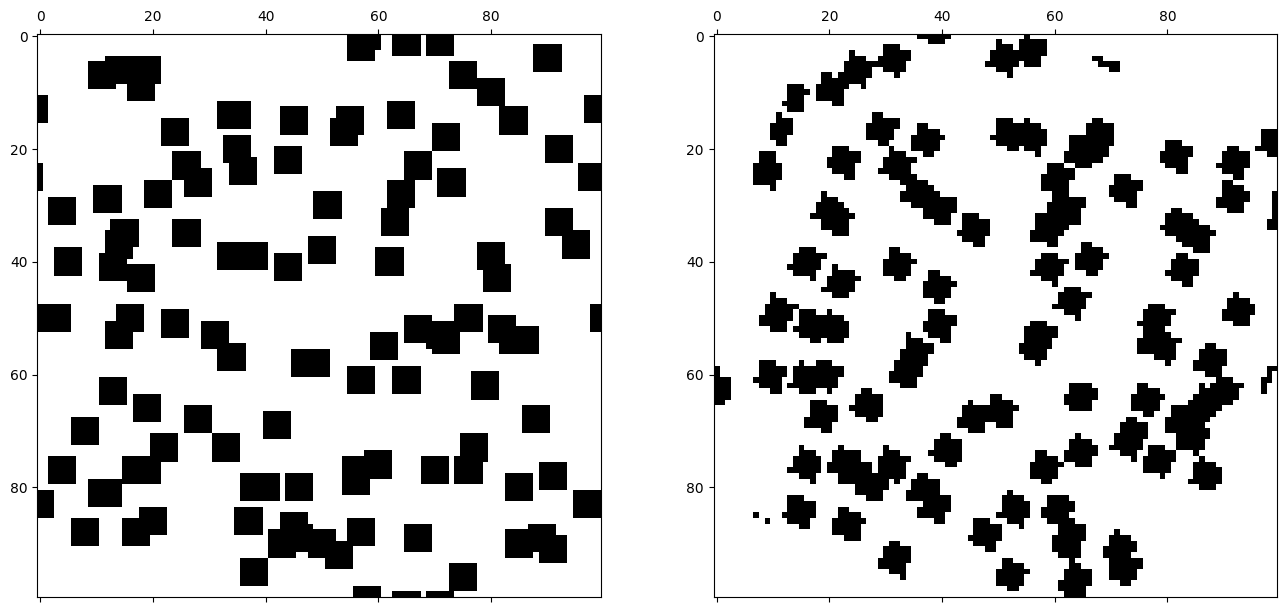

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
mat1, _ = tor_location(length=100, frac=0.25, scale=5, seed_no=689)
ax[0].matshow(mat1, cmap='binary')
ax[1].matshow(rotate_matrix(mat1, 67), cmap='binary')
plt.show()

In [31]:
np.random.seed(420)
length = 10
frac = 0.2
scale = 5
tor_no = int(length*length*(frac)/(scale**2))
# so bigger tors need to fit into the same fraction so we'll get fewer tors
# tor_no = int(length*length*(1-frac)/(scale**2))
tor_dens = tor_no/(length*length)
# here we define 'density' as the number of tors per unit area

print(f'Tor Number: {tor_no}')
print(f'Tor Density: {tor_dens}')

Tor Number: 0
Tor Density: 0.0


In [ ]:
# Example usage
length = 100
frac = 0.5
scale = 5
seed_no = 42

bedrock_map = tor_location(length, frac, scale, seed_no)

In [5]:
# Calculate tor_no and tor_dens directly in a single line
tor_no, tor_dens = int(length*length*(1-frac)/(scale**2)), int(length*length*(1-frac)/(scale**2))/(length*length)

# Generate random matrix and assign values based on condition in a single line
znew = np.where(np.random.random_sample((length, length)) > (1-tor_dens), 1, 0)


In [ ]:
import numpy as np

def create_matrix(frac, length):
    """
    Create a numpy matrix of dimension length x length with the 1's equal to the 
    fraction times length x length and 0's in the remainder. The 1's are uniformly
    randomly placed in the matrix.

    Parameters:
    frac (float): Fraction of 1's in the matrix. Should be between 0 and 1.
    length (int): The length of the sides of the matrix.

    Returns:
    np.ndarray: The resulting matrix.
    """
    # Calculate the total number of elements in the matrix
    total_elements = length * length

    # Calculate the number of 1's and 0's
    num_ones = int(frac * total_elements)
    num_zeros = total_elements - num_ones

    # Create a 1D array with the correct number of 1's and 0's
    arr = np.hstack([np.ones(num_ones, dtype=int), np.zeros(num_zeros, dtype=int)])

    # Shuffle the array to ensure the 1's are randomly placed
    np.random.shuffle(arr)

    # Reshape the 1D array into a 2D matrix of the required dimensions
    matrix = arr.reshape(length, length)

    return matrix


### Generate Bedrock Grid

In [9]:
def generate_grid(length: int, frac: float, scale: int, seed_no: int):
    # TRUTH grid
    # np.random.seed(seed_no)
    # z = np.random.random((length, length))
    # z = np.zeros((length,length))
    # np.random.seed(seed_no)
    # z += np.random.rand(length,length)
    # So, why are we doing this if we just overwrite it in the next line?

    z, _ = tor_location(length, frac, scale, seed_no)
    frac_actual = _[-1][2]
    #frac_actual = np.size(z[z==1])/(np.size(z)) #we've already calculated this in tor_location
    
    return [z, frac_actual]

In [133]:
mat, _ = generate_grid(length=100, frac=0.1, scale=2, seed_no=420)
type(mat)

numpy.ndarray

### Offset Input Grid by DN

We could do this more directly with `scipy.ndimage.shift`, but this is a bit more explicit.

In [14]:
def mat_offset(z: np.ndarray, offset_x: int, offset_y: int) -> Tuple[np.ndarray, float]:
    """
    Offsets a 2D numpy array by a given amount in the x and y directions.

    Args:
        z (numpy.ndarray): The input 2D numpy array.
        offset_x (int): The amount to offset the array in the x direction.
        offset_y (int): The amount to offset the array in the y direction.

    Returns:
        Tuple[numpy.ndarray, float]: A tuple containing the offset 2D numpy array and the fraction of 1's in the array.

    """
    from scipy.ndimage import shift

    new_z = shift(input=z, shift=(offset_y, offset_x), mode='grid-wrap')

    frac_actual = np.size(new_z[new_z==1])/(np.size(new_z))
    
    return new_z, frac_actual

In [11]:
def model_offset(z: np.ndarray, dn: int) -> Tuple[np.ndarray, float]:
    '''
    This function takes a 2D array and shifts the values by dn columns to the right.
    This logic doesn't work for negative values of dn (i.e. shifting to the left).
    We'll need throw an exception for that or fix that logic.
    '''
    [m,n] = z.shape
    zn = np.zeros([m,n])
        
    for j in range(n):
        if j < dn:
            zn[:,j] = z[:,(n-dn+j)]
        else:
            zn[:,j] = z[:,j-dn]
        
    frac_actual = np.size(zn[zn==1])/(np.size(zn))
    
    return [zn, frac_actual]   

Did not converge in fifty iterations.


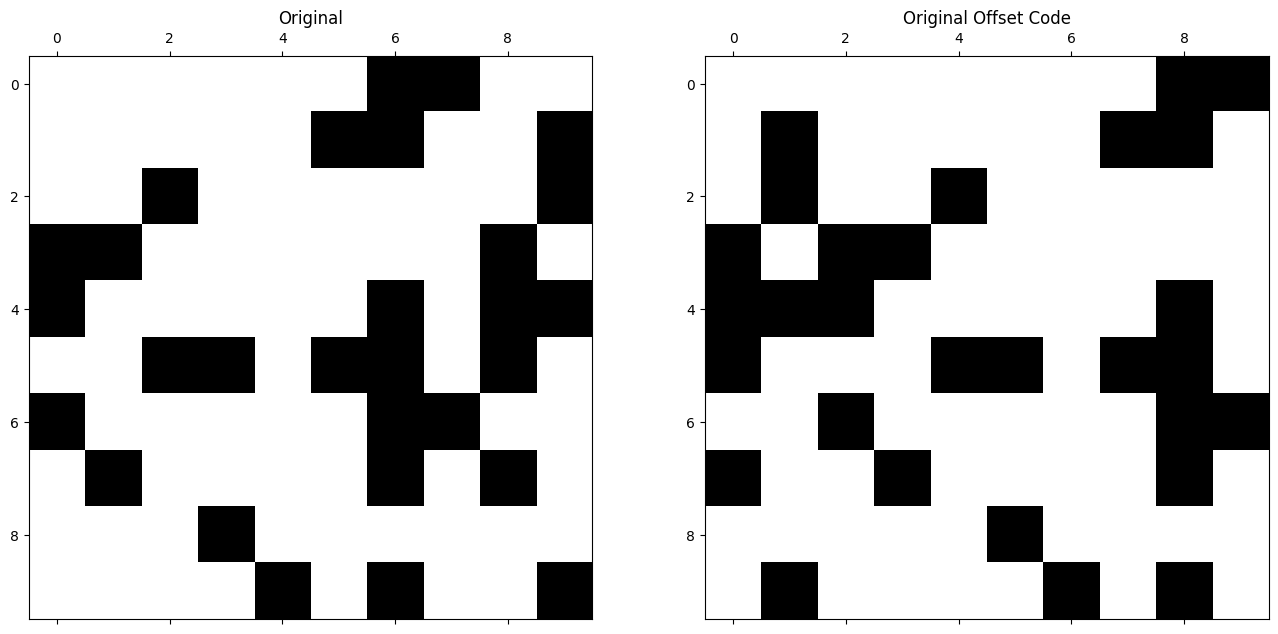

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

mat1, _ = generate_grid(length=10, frac=0.3, scale=1, seed_no=65)
ax[0].matshow(mat1, cmap='binary')
ax[0].set_title('Original')
mat2, _ = model_offset(z=mat1, dn=2)
ax[1].matshow(mat2, cmap='binary')
ax[1].set_title('Original Offset Code')

plt.show()

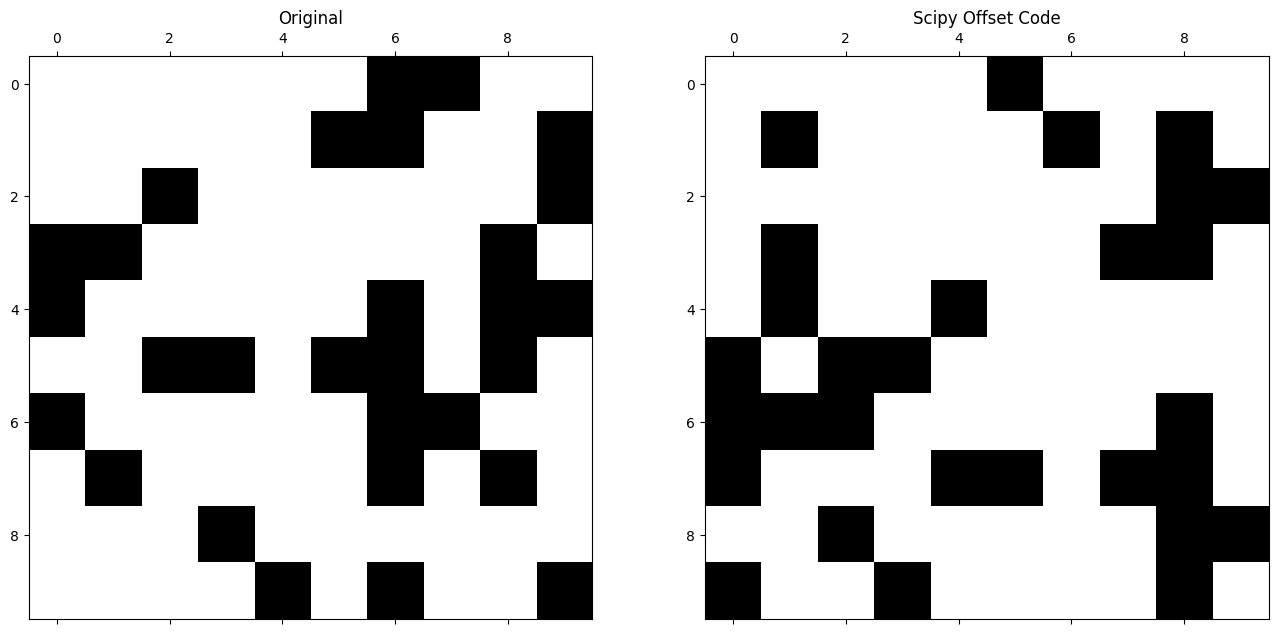

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

#mat1, _ = generate_grid(length=10, frac=0.2, scale=1, seed_no=65)
ax[0].matshow(mat1, cmap='binary')
ax[0].set_title('Original')
mat2, _ = mat_offset(z=mat1, offset_x=2, offset_y=2)
ax[1].matshow(mat2, cmap='binary')
ax[1].set_title('Scipy Offset Code')

plt.show()

### Modify Input Grid using a Constant Error Rate

Where are we going with this?

*
*

In [8]:
def model_rand_err(z: np.ndarray, err: float, seed_no: int) -> Tuple[np.ndarray, float]:
    """_summary_

    Args:
        z (np.ndarray): _description_
        err (float): Error Rate (between 0 and 1??)
        seed_no (int): _description_

    Returns:
        Tuple[np.ndarray, float]: _description_
    """
    [m,n] = z.shape
    zn = np.zeros([m,n]) # initialize np.array of zeros of shape z
    ze = np.zeros([m,n]) # initialize np.array of zeros of shape z
    # ze is the 'error' matrix, which is a matrix that flips an error bit on a matrix the same size as z
    # zn is the 'new' matrix, after flipping errors
    # Not so much flipping errors as it is just adding more random noise to the matrix??
    np.random.seed(seed_no)
    ze += np.random.rand(m,n) # supefolous step, we can just use ze = np.random.rand(m,n)
    ze[ze>=err] = 1
    ze[ze<err] = 0
    ze = 1 - ze
    
    # Fast enough for the time being, vectorize though...
    for i in range(m):
        for j in range(n):
            if ze[i,j] == 1: # if the error bit has been flipped at loc(i, j)
                zn[i,j] = z[i,j] + 2 # if no bedrock == 2, if bedrock == 3
            else: # no error bit has been flipped at loc(i, j), so just copy the value from z
                zn[i,j] = z[i,j]

    #zn[zn==2] = 1
    #zn[zn==3] = 0
    zk = zn.copy()
    zk[zk==2] = 1
    zk[zk==3] = 0

    # frac_actual = np.size(zn[zn==1])/(np.size(zn))
    frac_actual = np.size(zk[zk==1])/(np.size(zk))
    # return ze, zn, zk
    return [zk, frac_actual]   

In [189]:
mat_err, mat_dis, mat_new = model_rand_err(z=mat1, err=0.3, seed_no=23)

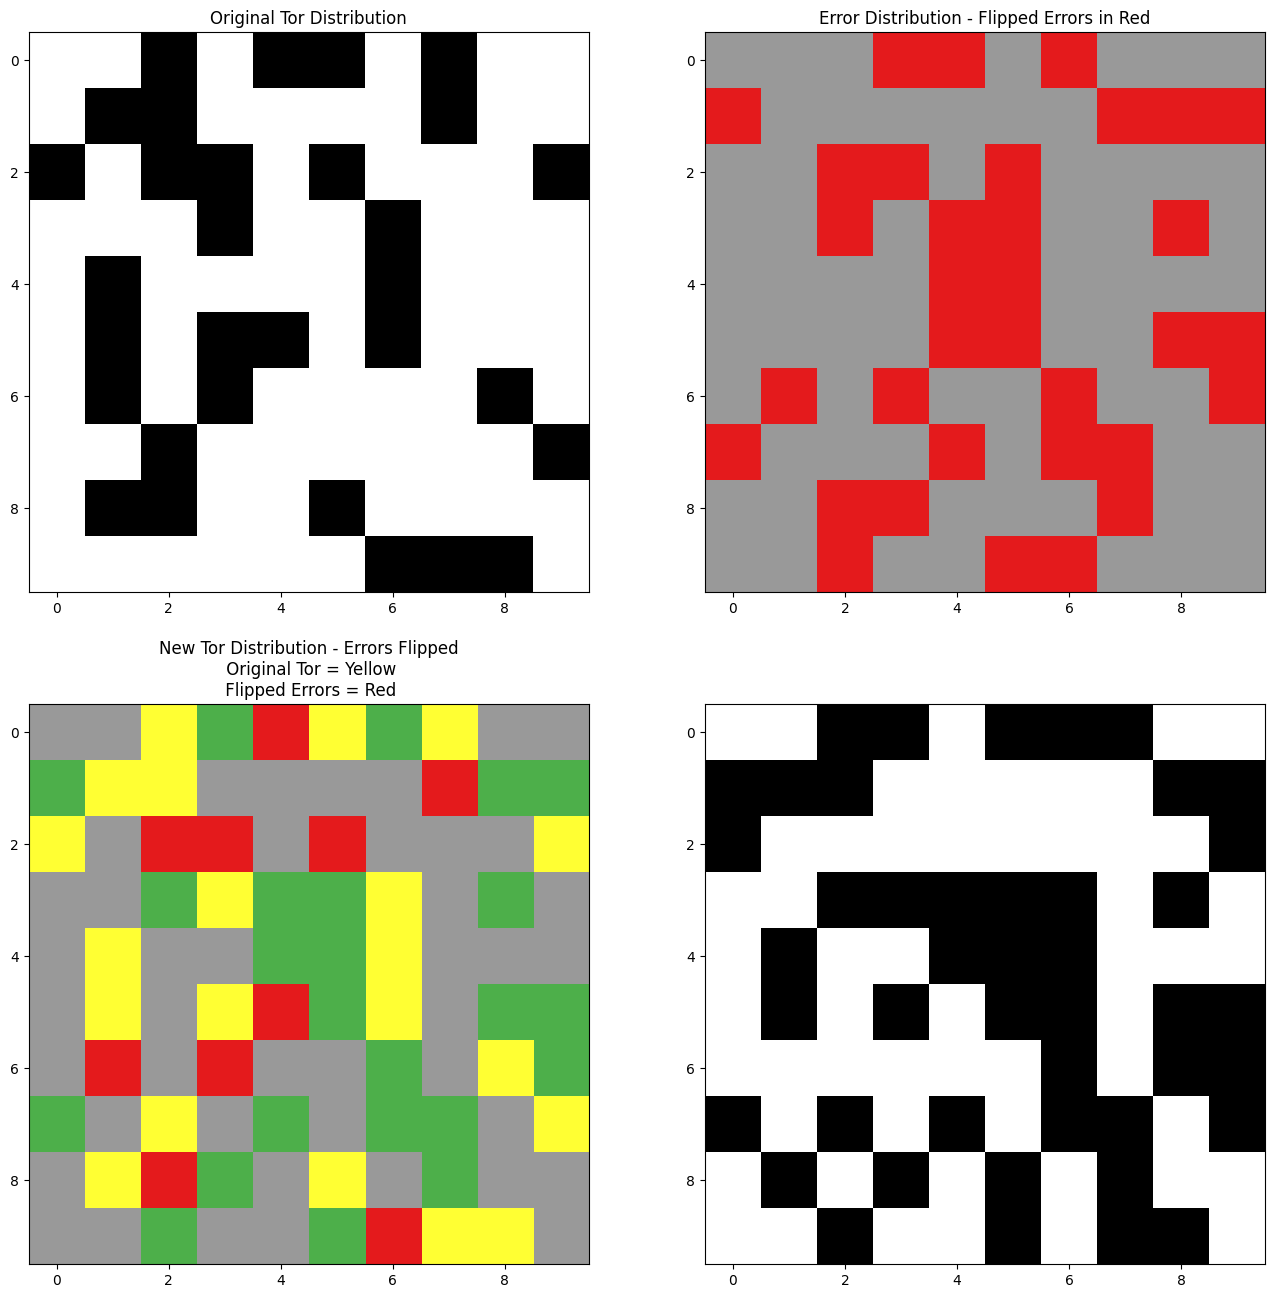

In [190]:
f, ax = plt.subplots(2, 2, figsize=(16,16))

ax[0,0].imshow(mat1, cmap='binary')
ax[0,0].set_title('Original Tor Distribution')
ax[0,1].imshow(mat_err, cmap='Set1_r')
ax[0,1].set_title('Error Distribution - Flipped Errors in Red')
ax[1,0].imshow(mat_dis, cmap='Set1_r')
ax[1,0].set_title('New Tor Distribution - Errors Flipped\n Original Tor = Yellow\n Flipped Errors = Red')
ax[1,1].imshow(mat_new, cmap='binary')
plt.show()

### Tor Shapes

## Step Through Main

In [9]:
l = 10            # grid length [pixels]
scl = 1            # tor length [pixels]
# sflag = 5           # 1: 'con', 2: 'ind', 3: 'ran', 4: 'sys', 5: 'sys + ran' 
# fmap = 0.5          # draw map at bedrock fraction = fmap
# con = 0             # uniform SOIL fraction [only used for sflag: {1}]
# off = 3             # offset [pixels] [only used for sflag: {4,5}]
rand = 0.05         # random error rate [only used for sflag: {3,5}]

f = np.linspace(start=0.3, stop=0.4, num=2)     # target SOIL fractions
ft = np.zeros(len(f))                           # true BEDROCK fractions
fm = np.zeros(len(f))                           # model BEDROCK fractions

### Generate a 'truth' grid for each soil fraction

`[zt, ft[i]] = generate_grid(leng=l, frac=f[i], seed_no=1, scale=scl) `

Did not converge in fifty iterations.
Did not converge in fifty iterations.


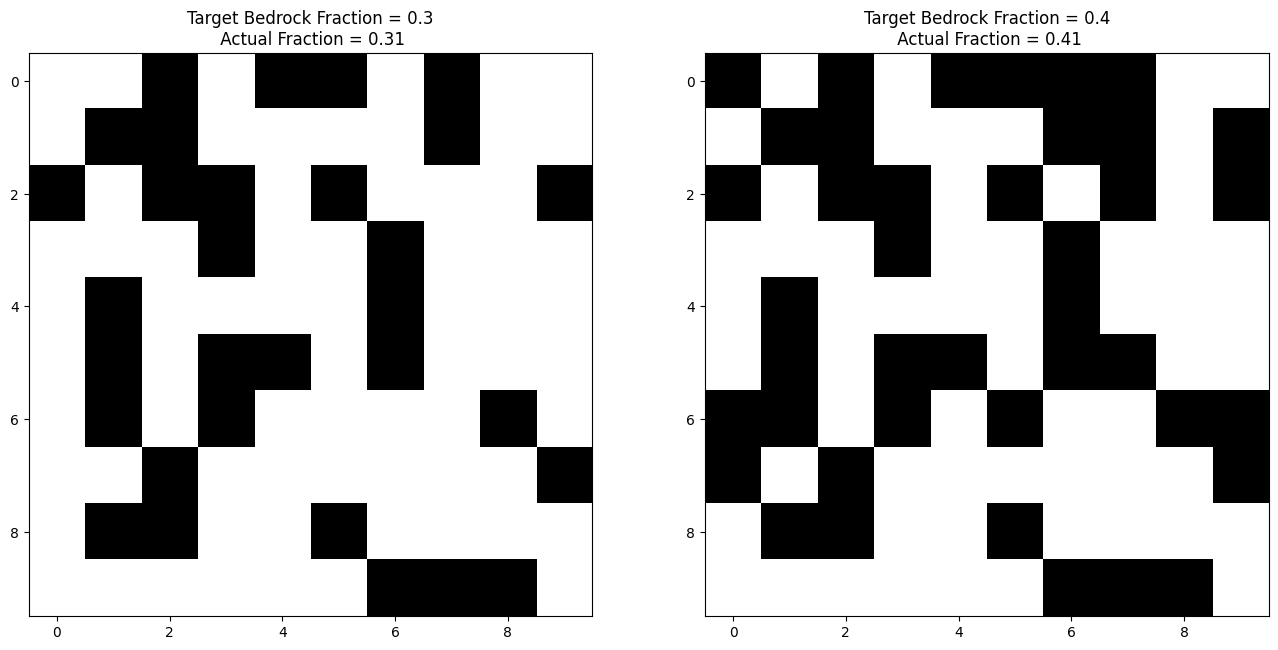

In [10]:
zt_0, frac_0 = generate_grid(length=l, frac=f[0], scale=scl, seed_no=18)
zt_1, frac_1 = generate_grid(length=l, frac=f[1], scale=scl, seed_no=18)

fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].imshow(zt_0, cmap='binary')
ax[0].set_title('Target Bedrock Fraction = {}\n Actual Fraction = {}'.format(f[0], frac_0))
ax[1].imshow(zt_1, cmap='binary')
ax[1].set_title('Target Bedrock Fraction = {}\n Actual Fraction = {}'.format(f[1], frac_1))
plt.show()

### Truth Model Scenarios

#### CONSTANT FRACTION - _Truth_ varies but _Model_ does not

`sflag==1`

`[zm, fm[i]] = gf.generate_grid(leng=l, frac=con, seed_no=2, scale=scl)`

`con = 0 # uniform SOIL fraction [only used for sflag: {1}]`

In [11]:
# same representation, but with a different random seed
# Uniform Soil Fraction
zm_0, fm_0 = generate_grid(length=l, frac=1, scale=scl, seed_no=215)
zm_1, fm_1 = generate_grid(length=l, frac=1, scale=scl, seed_no=215)

#### FRACTION MATCH - Tor location independent of _Truth_

`elif sflag==2`

`[zm, fm[i]] = gf.generate_grid(leng=l, frac=f[i], seed_no=2, scale=scl)  `

Gets the same Bedrock(Soil) Fraction as the Ground Truth Model.

Did not converge in fifty iterations.


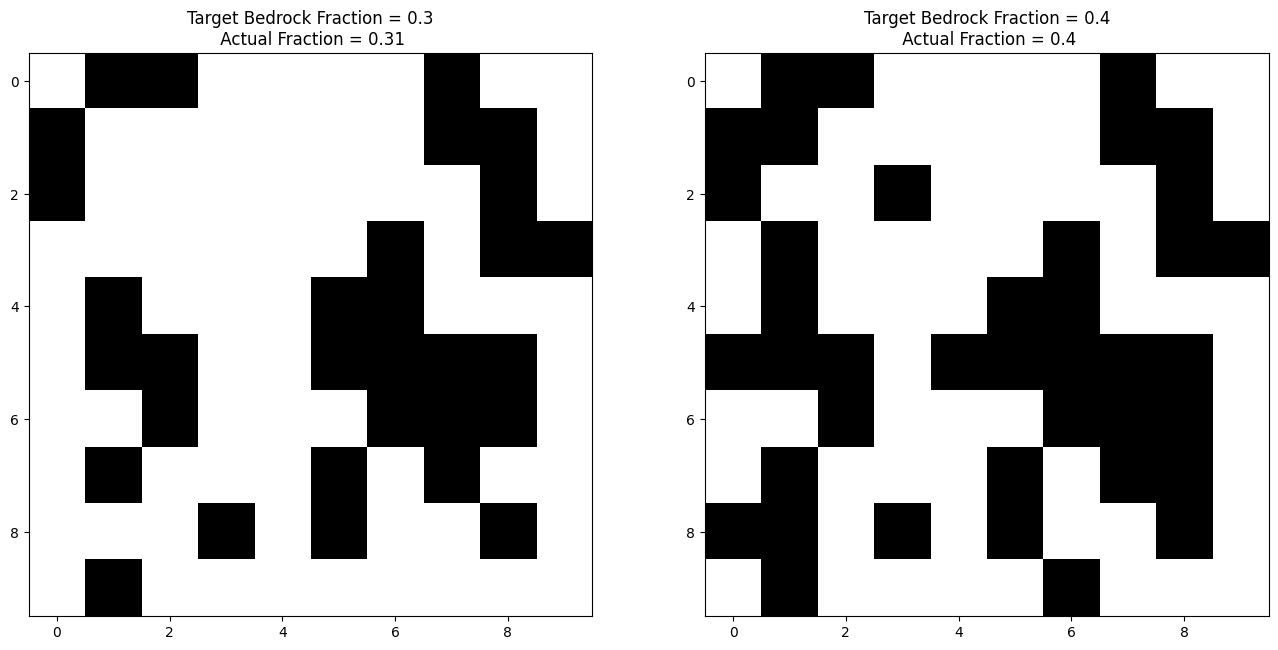

In [15]:
# same representation, but with a different random seed
# Same Soil Fraction
zm_0, fm_0 = generate_grid(length=l, frac=f[0], scale=scl, seed_no=889)
zm_1, fm_1 = generate_grid(length=l, frac=f[1], scale=scl, seed_no=889)

fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].imshow(zm_0, cmap='binary')
ax[0].set_title('Target Bedrock Fraction = {}\n Actual Fraction = {}'.format(f[0], fm_0))
ax[1].imshow(zm_1, cmap='binary')
ax[1].set_title('Target Bedrock Fraction = {}\n Actual Fraction = {}'.format(f[1], fm_1))
plt.show()